In [1]:
import pandas as pd
import numpy as np
import time, os, sys, gc, json

from IPython.display import clear_output

import matplotlib as plt
%matplotlib inline
plt.style.use('dark_background')

In [2]:
from Models.framework_utils import *
from Models.diagnostic_utils import *

# load numerapi
public_id, secret_key = get_numerapi_config()
import numerapi
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)
modelnames = napi.get_models()

# load data
ds_version = "v4.1"
dataset_loc = os.path.join(os.getcwd(), 'train_datasets', ds_version)
currentRound = get_update_training_data(napi, dataset_loc)

numerapi ID and Key loaded from config.json
Datasets are up to date.
Current Round: 544


In [3]:
np.random.seed(42)
print("# Loading data... ",end='')

# training data T* | X = features, Ys = targets, I = era indices
TX, TYs, TI, features, targets = processData(os.path.join(dataset_loc, 'train.parquet'), return_fts=True)
primary_target = np.arange(len(targets))[['target' == x for x in targets]][0]
TY = TYs[:,primary_target]

with open(os.path.join(dataset_loc, "features.json"), "r") as f:
    feature_metadata = json.load(f)
    
small_features = np.arange(len(features))[np.isin(features,feature_metadata['feature_sets']['small'])]
medium_features = np.arange(len(features))[np.isin(features,feature_metadata['feature_sets']['medium'])]

# validation data V*
VX, VYs, VI = processData(os.path.join(dataset_loc, 'validation.parquet'))
VY = VYs[:,primary_target]

# MMP = pd.read_parquet(os.path.join(dataset_loc, 'meta_model.parquet'), engine="fastparquet").values[:,0]
EVP = pd.read_parquet(os.path.join(dataset_loc, 'validation_example_preds.parquet'),engine="fastparquet").values[:,0]

gc.collect()
print("done")

# Loading data... done


In [4]:
import lightgbm

params = {"n_estimators": 2000,
          "learning_rate": 0.01,
          "max_depth": 5,
          "num_leaves": 2 ** 5,
          "colsample_bytree": 0.1}

lgbm_model = lightgbm.LGBMRegressor(**params)

lgbm_model.fit(TX, TY)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7930
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 1586
[LightGBM] [Info] Start training from score 0.500015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, num_leaves=32)

In [5]:
VP = lgbm_model.predict(VX)

C:\Users\Alex\AppData\Local\Temp\ipykernel_22268\2101422940.py:9: RuntimeWarning: invalid value encountered in divide
  return prod / np.sqrt(ddiffs2 * idiff2)


corrv2 mean : 0.026504
corrv2 sdev : 0.022738
corrv2 sharpe : 1.165652
corrv2 sortino (-0.02) : 0.494859
corrv2 drawdown : -0.16326
fnc mean : 0.020305
fnc sdev : 0.017645
fnc sharpe : 1.150754
fnc sortino (-0.02) : 0.025536
fnc drawdown : -0.085755
mean abs feature exposure : 0.063064
max abs feature exposure : 0.212305
sdev feature exposure : 0.034983
example_preds corr (preds) mean : 0.704924
example_preds corr (preds) sdev : 0.048513


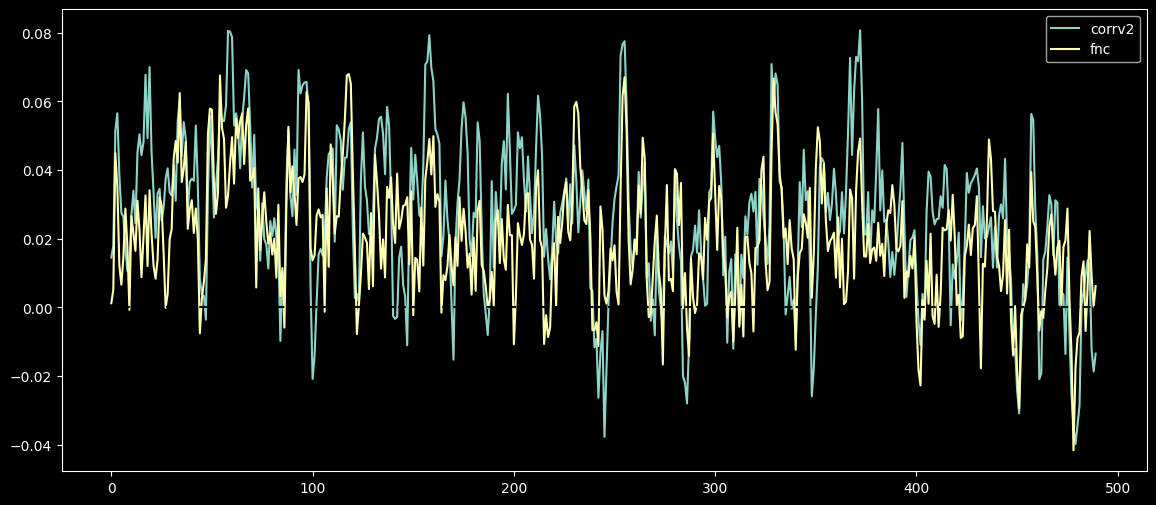

In [23]:
VId = VI[5:-5] # remove first 5 eras of validation to prevent lookahead bias from the training data, remove last 5 as they are unresolved
validation_diagnostics, validation_corrs = run_diagnostics(VP,VY,VX[:,medium_features],VId, featexp=True, fnc=True, 
                                                           print_output=True, graph_corrs=True, compare={'example_preds': EVP})

In [11]:
lgbm_model.booster_.save_model(os.path.join(os.getcwd(), 'Models', 'Modeldata', 'lgbm_model.txt'))
np.save(os.path.join(os.getcwd(), 'Models', 'Modeldata', 'lgbm_model_features.npy'), features)